In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from tqdm import tqdm
FLAGS = edict()

# FLAGS.weights ='./checkpoints/day_tw_qat_tf23/save_model_final_tflite/'
FLAGS.weights ='./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/'
FLAGS.output ='./checkpoints/tmp.tflite'
FLAGS.input_size =608
FLAGS.quantize_mode ='float32'
FLAGS.dataset ="datasets/data_selection_mix/anno/val_3cls.txt"


2022-06-27 19:48:43.643599: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


file /home/user/anaconda3/envs/WJtf29/lib/python3.8/site-packages/tensorflow/lite/python/interpreter is not end with tflite_runtime/interpreter


In [3]:
def representative_data_gen():
  len_img=50
  fimage = open(FLAGS.dataset).readlines()
  fimage = [line.split()[0] for line in fimage]
  np.random.seed(0)
  np.random.shuffle(fimage)
  with tqdm(total=len_img, ncols=200) as pbar:
    for input_value in range(len_img):
      if os.path.exists(fimage[input_value]):
        original_image=cv2.imread(fimage[input_value])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        # Processing V1
        # image_data = utils.image_preprocess(np.copy(original_image), [FLAGS.input_size, FLAGS.input_size])
        #####################################################################################################
        # Processing V2
        image_data = cv2.resize(np.copy(original_image), (FLAGS.input_size, FLAGS.input_size))
        image_data = image_data / 255.0
        #####################################################################################################
        img_in = image_data[np.newaxis, ...].astype(np.float32)
        pbar.set_postfix({
          'image': fimage[input_value]
        })
        pbar.update(1)
        yield [img_in]
      else:
        pbar.set_postfix({
          'image': ''
        })
        pbar.update(1)

def add_statistic(filename):
  layer_stats = pd.read_csv(filename)
  print(layer_stats.head())
  layer_stats['range'] = 255.0 * layer_stats['scale']
  layer_stats['rmse/scale'] = layer_stats.apply(
      lambda row: np.sqrt(row['mean_squared_error']) / row['scale'], axis=1)
  return layer_stats
  # layer_stats[['op_name', 'range', 'rmse/scale']].head()
  

In [5]:
if not os.path.exists(os.path.dirname(FLAGS.output)):
  os.makedirs(os.path.dirname(FLAGS.output))
converter = tf.lite.TFLiteConverter.from_saved_model(FLAGS.weights)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
debugger = tf.lite.experimental.QuantizationDebugger(
  converter=converter, debug_dataset=representative_data_gen)
debugger.run()


origin_int8_model = debugger.get_nondebug_quantized_model()
num_of_bytes = open('./origin_int8_model.tflite', 'wb').write(origin_int8_model)
print(f'origin model {num_of_bytes} bytes')

RESULTS_FILE = './debugger_results.csv'
RESULTS_FILE_V2 = './debugger_results_V2.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)
layer_stats = add_statistic(RESULTS_FILE)
layer_stats.to_csv(RESULTS_FILE_V2)


2022-06-27 19:51:15.889299: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-27 19:51:15.889345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-27 19:51:15.889527: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 19:51:15.928767: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-27 19:51:15.928819: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 19:51:16.059778: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-27 19:51:16.540086: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 19:51:16.750453: I

origin model 6011416 bytes
   op_name  tensor_idx  num_elements    stddev  mean_error  max_abs_error  \
0     RELU         118     2957312.0  0.006270   -0.002940       0.122591   
1      PAD         122     2976800.0  0.000000    0.000000       0.000000   
2  CONV_2D         126     1478656.0  0.173421    0.000573       0.929668   
3     RELU         130     1478656.0  0.048481    0.006388       0.131863   
4  CONV_2D         134     1478656.0  0.110942    0.000437       0.963905   

   mean_squared_error     scale  zero_point  \
0            0.000050  0.247125        -128   
1            0.000000  0.247125        -128   
2            0.030075  0.600441          14   
3            0.002393  0.266078        -128   
4            0.012308  0.384223          27   

                                         tensor_name  
0                              model/tf.nn.relu/Relu  
1                   model/quant_zero_padding2d_1/Pad  
2  model/quant_batch_normalization_1/FusedBatchNo...  
3      

fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


''

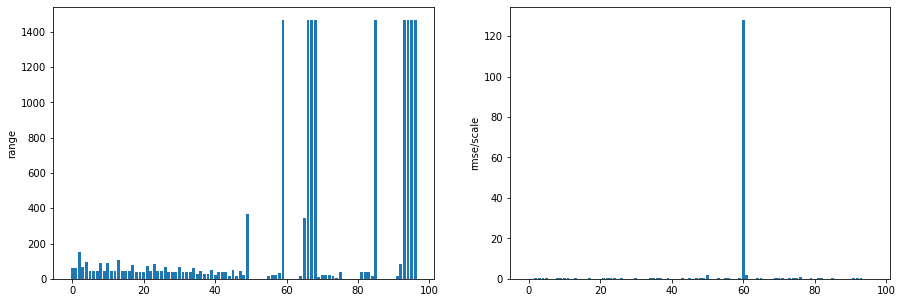

In [6]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
ax1.set_ylabel('range')
ax2 = plt.subplot(122)
ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
ax2.set_ylabel('rmse/scale')
plt.savefig('int8_analysis.jpg')

In [ ]:
# threshold=0.28 #0.295 # 1./np.sqrt(12) + 0.0001 # 0.30
# print(threshold)
# layer_stats[layer_stats['rmse/scale'] > threshold][[
#     'op_name', 'range', 'rmse/scale', 'tensor_name', 'mean_squared_error', 'scale', 'num_elements'
# ]]

In [46]:
threshold=0.0
suspected_layers = list(layer_stats[layer_stats['rmse/scale'] > threshold]['tensor_name'])
# suspected_layers = list(layer_stats[layer_stats['rmse/scale'] < threshold]['tensor_name'])
# suspected_layers = list(layer_stats['tensor_name'])
print(f'num of freeze layer {len(suspected_layers)}/{len(layer_stats)}', )
print(np.array(suspected_layers))
# discrad quant of first few layers would also increase performance
# suspected_layers.extend(list(layer_stats[:5]['tensor_name']))
# suspected_layers = np.unique(np.array(suspected_layers))
# print(suspected_layers)

num of freeze layer 65/97
['model/tf.nn.relu/Relu'
 'model/quant_batch_normalization_1/FusedBatchNormV3;model/quant_conv2d_8/Conv2D;model/quant_conv2d_1/Conv2D'
 'model/tf.nn.relu_1/Relu'
 'model/quant_batch_normalization_2/FusedBatchNormV3;model/quant_conv2d_8/Conv2D;model/quant_conv2d_2/Conv2D'
 'model/tf.nn.relu_2/Relu'
 'model/quant_batch_normalization_3/FusedBatchNormV3;model/quant_conv2d_4/Conv2D;model/quant_conv2d_3/Conv2D'
 'model/tf.nn.relu_3/Relu'
 'model/quant_batch_normalization_4/FusedBatchNormV3;model/quant_conv2d_4/Conv2D'
 'model/tf.nn.relu_4/Relu'
 'model/quant_batch_normalization_5/FusedBatchNormV3;model/quant_conv2d_8/Conv2D;model/quant_conv2d_5/Conv2D'
 'model/tf.nn.relu_5/Relu'
 'model/quant_batch_normalization_6/FusedBatchNormV3;model/quant_conv2d_12/Conv2D;model/quant_conv2d_6/Conv2D'
 'model/tf.nn.relu_6/Relu'
 'model/quant_batch_normalization_7/FusedBatchNormV3;model/quant_conv2d_8/Conv2D;model/quant_conv2d_7/Conv2D'
 'model/tf.nn.relu_7/Relu'
 'model/quant_bat

In [44]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=suspected_layers)
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_data_gen,
    debug_options=debug_options)


2022-06-27 22:39:27.117842: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-06-27 22:39:27.117887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-06-27 22:39:27.118103: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 22:39:27.148816: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-06-27 22:39:27.148877: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 22:39:27.278948: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-27 22:39:27.814661: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./checkpoints/day_tw_qat_tf29/save_model_0059_tflite/
2022-06-27 22:39:28.018196: I

In [45]:
# selective_quantized_model = debugger.get_nondebug_quantized_model()
# open('./checkpoints/day_tw_qat_tf29/selective_int8_thresh_29.tflite', 'wb').write(selective_quantized_model)
# 39 23596392 
# 46 23596960 
# 58 23599040 
# 65 23598584 
# 97 23591704 
# rev 38 6017440 
selective_quantized_model_dbg = debugger.get_nondebug_quantized_model()
num_of_bytes = open(f'./selective_int8_model_rev_{len(suspected_layers)}layer.tflite', 'wb').write(selective_quantized_model_dbg)
print(f'selective model {num_of_bytes} bytes')

selective model 6017440 bytes


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0
